# Tarea 4: Psicrometría
### Pablo Correa e Ian Gross

## Librerías

In [2]:
import CoolProp.CoolProp as cp
import fluids as fld
import numpy as np
import scipy.constants as cte
import scipy.optimize as opt
import matplotlib.pyplot as plt

from fluids.units import *

from PIL import Image

In [3]:
g = cte.g*u.m/u.s**2
Patm = (1*u.atm).to(u.Pa)

# Pregunta 1
Un flujo de aire (corriente 1) a 60°F , 1 atm y 30 % de humedad relativa se mezcla adiabáticamente
con un flujo de aire (corriente 2) a 90°F , 1 atm y 80 % de humedad relativa. Una sola corriente (corriente
3) sale de la cámara de mezcla a una temperatura T3 y 1 atm. Suponga un estado estacionario e ignore
los efectos de energía cinética y potencial. Sea r la relación de los caudales másicos de aire seco  ̇$\dot{m}_{a,1}/\dot{m}_{a,2}$:

(a) (3 pts) Determine T3, en ◦C, para r = 2.

(b) (3 pts) Ilustre el proceso de mezcla en un diagrama psicrométrico.

(c) (3 pts) Construya un gráfico de T3 versus r, variando r de 0 a 10.

## Parte A

In [4]:
T_1 = (60*u.fahrenheit).to(u.kelvin)
T_2 = (90*u.fahrenheit).to(u.kelvin)
HR_1 = 0.3
HR_2 = 0.8

P = Patm
r = 2

Utilizando la humedad relativa, se obtiene la humedad absoluta y la entalpía específica para las corrientes de entrada (1 y 2)

In [5]:
w_1 = cp.HAPropsSI('W', 'T', T_1.magnitude, 'R', HR_1, 'P', P.magnitude)
h_1 = cp.HAPropsSI('H', 'T', T_1.magnitude, 'R', HR_1, 'P', P.magnitude)*u.joule/u.kilogram

w_2 = cp.HAPropsSI('W', 'T', T_2.magnitude, 'R', HR_2, 'P', P.magnitude)
h_2 = cp.HAPropsSI('H', 'T', T_2.magnitude, 'R', HR_2, 'P', P.magnitude)*u.joule/u.kilogram

Las ecuaciones de balance de masa, masa humeda y energía para el caso de mezcla adiabática son

$$\dot{m}_1 + \dot{m}_2 = \dot{m}_3$$

$$\dot{m}_1 \omega_1 + \dot{m}_2 \omega_2 = \dot{m}_3 \omega_3$$

$$\dot{m}_1 h_1 + \dot{m}_2 h_2 = \dot{m}_3 h_3$$

Dada la definición de $r$ y el balance de masas se tiene que

$$\dot{m}_1 = r \dot{m}_2$$

$$\dot{m}_3 = (1 + r)\dot{m}_2$$

Con estos resultados se tiene que la humedad absoluta y entalpía específica de salida serían

$$\omega_3 = \frac{r \omega_1 + \omega_2}{r + 1}$$

$$h_3 = \frac{r h_1 + h_2}{r + 1}$$

In [6]:
def corriente_3(corriente_1, corriente_2, r):
    value = (r*corriente_1 + corriente_2)/(r+1)
    return value

w_3 = corriente_3(w_1, w_2, r)
h_3 = corriente_3(h_1, h_2, r)

print(w_1, w_2, w_3)

0.0032858262222819723 0.024717042648684476 0.010429565031082806


Luego, utilizando la humedad específica y la entalpía específica en la corriente 3, se puede utilizar CoolProp para obtener la temperatura correspondiente en la corriente 3.

In [7]:
T_3 = cp.HAPropsSI('T', 'W', w_3, 'H', h_3.magnitude, 'P', P.magnitude)

T_3 = (T_3*u.kelvin).to(u.celsius)
print(f"Temperatura de Salida: {T_3}")

Temperatura de Salida: 21.252768065219698 degree_Celsius


## Parte B

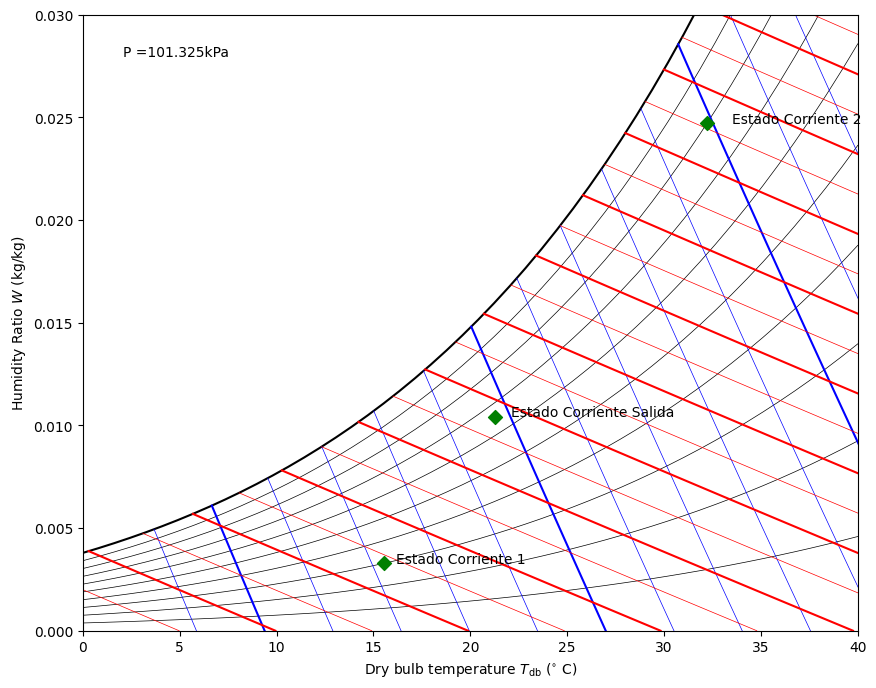

In [8]:
fig, ax = plt.subplots(1,1,figsize=(10, 8))
Tdbvec = np.linspace(0, 40)+273.15

# Lines of constant relative humidity
for RH in np.arange(0.1, 1, 0.1):
    W = cp.HAPropsSI("W","R",RH,"P",P.magnitude,"T",Tdbvec)
    plt.plot(Tdbvec-273.15, W, color='k', lw = 0.5)

# Saturation curve
W = cp.HAPropsSI("W","R",1,"P",P.magnitude,"T",Tdbvec)
plt.plot(Tdbvec-273.15, W, color='k', lw=1.5)

# Lines of constant Vda
for Vda in np.arange(0.79, 1.041, 0.01):
    R = np.linspace(0,1)
    W = cp.HAPropsSI("W","R",R,"P",P.magnitude,"Vda",Vda)
    Tdb = cp.HAPropsSI("Tdb","R",R,"P",P.magnitude,"Vda",Vda)
    plt.plot(Tdb-273.15, W, color='b', lw=1.5 if abs(Vda % 0.05) < 0.001 else 0.5)

# Lines of constant Enthalpy
for h in np.arange(0, 120, 5):
    R = np.linspace(0.0, 1)
    Tdb = cp.HAPropsSI("Tdb","R",R,"P",P.magnitude,"H",h*1000)
    W = cp.HAPropsSI("W","R",R,"P",P.magnitude,"Tdb",Tdb)
    plt.plot(Tdb-273.15, W, color='r', lw=1.5 if abs(h % 10) < 0.001 else 0.5)

ax.annotate('P =' + f'{P.magnitude/1000}' + 'kPa', xy=(2, 0.0275), xytext=(2.1,0.028))

# Puntos con los estado termodinámicos
e_h = 1.04 # Espaciamiento horizontal
# Estado Corriente 1
plt.scatter(T_1.to(u.celsius).magnitude, w_1, c='g',s=50,zorder=5,marker='D') 
plt.annotate('Estado Corriente 1', ((T_1.to(u.celsius).magnitude)*e_h, w_1))
# Estado Corriente 1
plt.scatter(T_2.to(u.celsius).magnitude, w_2, c='g',s=50,zorder=5,marker='D') 
plt.annotate('Estado Corriente 2', ((T_2.to(u.celsius).magnitude)*e_h, w_2))
# Estado Corriente 3
plt.scatter(T_3.to(u.celsius).magnitude, w_3, c='g',s=50,zorder=5,marker='D') 
plt.annotate('Estado Corriente Salida', ((T_3.to(u.celsius).magnitude)*e_h, w_3))

plt.xlabel(r'Dry bulb temperature $T_{\rm db}$ ($^{\circ}$ C)')
plt.ylabel(r'Humidity Ratio $W$ (kg/kg)')
plt.ylim(0, 0.03)
plt.xlim(0, 40)
plt.show()

## Parte C

Aplicando la solución para la parte (a), se resuelve y se grafica la temperatura en la corriente 3 en relación a la razón $r$.

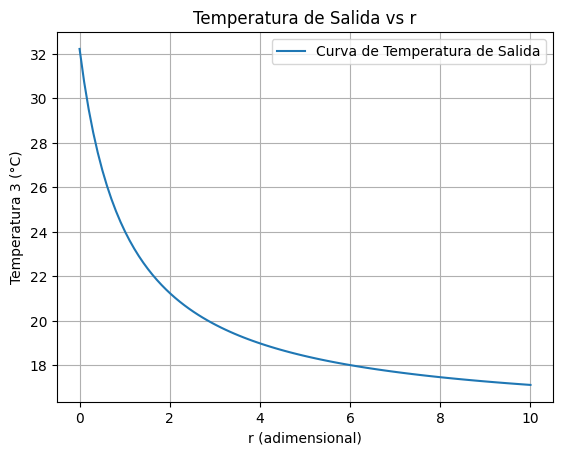

In [9]:
def Temp_3(w_1, w_2, h_1, h_2, r):
    w_3 = corriente_3(w_1, w_2, r)
    h_3 = corriente_3(h_1, h_2, r)
    T_3 = cp.HAPropsSI('T', 'W', w_3, 'H', h_3.magnitude, 'P', P.magnitude)*u.kelvin

    return T_3.to(u.celsius)

r_range = np.linspace(0,10,100)

T_3_range = [Temp_3(w_1, w_2, h_1, h_2, r_range[i]).magnitude for i in range(100)]

# plot curva de sistema
plt.plot(r_range, T_3_range, label='Curva de Temperatura de Salida')

# aspectos visuales
plt.xlabel('r (adimensional)')
plt.ylabel('Temperatura 3 (°C)')
plt.title('Temperatura de Salida vs r')
plt.legend()
plt.grid(True)
plt.show()

# Pregunta 2
Se debe suministrar, en estado estacionario, aire húmedo a una sala de clases a una tasa de flujo
volumétrico y temperatura T especificadas. El aire es retirado de la sala en una corriente diferente que
se encuentra a una temperatura de 27°C y 50 % de humedad relativa. Se agrega humedad al aire en
la habitación desde los ocupantes a una tasa de 4,5 kg/h. La humedad puede considerarse como vapor
saturado a 33°C. La transferencia de calor al espacio ocupado desde todas las fuentes se estima en
34,000 kJ/h. La presión permanece uniforme en 1 atm.

(a) (3 pts) Para una tasa de flujo volumétrico de aire suministrado de 40 m3/min, determine la
temperatura del aire suministrado T , en °C, y la humedad relativa.

(b) (3 pts) Ilustre el proceso de mezcla en un diagrama psicrométrico.

(c) (3 pts) Construya un gráfico de la temperatura del aire suministrado, en °C , y la humedad
relativa,ambas vs la tasa de flujo volumétrico de aire suministrado, variando esta última de 35 a
90 m3/min.

## Parte A

In [10]:
T_out = (27*u.celsius).to(u.kelvin)
HR_out = 0.5

m_v = (4.5*u.kg/u.hour).to(u.kg/u.s)
T_v = (33*u.celsius).to(u.kelvin)

q_in = (34000*u.kJ/u.h).to(u.W)

P = Patm
flow_rates_in = (40*u.m**3/u.min).to(u.m**3/u.s)

Usando los datos entregados, se calcula con CoolProp la humedad específica, entalpía y flujo másico que circula por la sala.

Para el flujo másico se considera que

$$\dot{m}_a = \frac{\dot{V}}{v}$$

In [11]:
w_out = cp.HAPropsSI('W', 'T', T_out.magnitude, 'R', HR_out, 'P', P.magnitude)
h_out = cp.HAPropsSI('H', 'T', T_out.magnitude, 'R', HR_out, 'P', P.magnitude)*u.joule/u.kilogram

V = cp.HAPropsSI('V', 'T', T_out.magnitude, 'R', HR_out, 'P', P.magnitude)*u.m**3/u.kilogram
m_a = flow_rates_in / V

Para resolver el problema considerandolo como un problema de humidificación se resuelve el balance de masa de humedad y de entalpía del sistema, considerando que la masa del sistema es constante

$$\dot{m}_{air} \omega_{in} + \dot{m}_{vapor} = \dot{m}_{air} \omega_{out}$$

$$\dot{m}_{air} h_{in} = \dot{m}_{air} h_{out} + \dot{Q}$$

Se considera que la entalpía asociada a la humedad es despreciable. Resolviendo para la humedad y entalpía específica de salida se tiene que

$$\omega_{in} = \omega_{out} - \frac{\dot{m}_{vapor}}{\dot{m}_{air}}$$

$$h_{in} = h_{out} + \frac{\dot{Q}}{\dot{m}_{air}}$$

Resolviendolo numerícamente, resulta en

In [12]:
w_in = w_out - m_v/m_a
h_in = h_out + q_in/m_a

T_in = (cp.HAPropsSI('T', 'H', h_in.magnitude, 'W', w_in.magnitude, 'P', P.magnitude)*u.kelvin).to(u.celsius)
R_in = cp.HAPropsSI('R', 'H', h_in.magnitude, 'W', w_in.magnitude, 'P', P.magnitude)

print(f"Temperatura de entrada: {T_in}")
print(f"Humedad relativa de entrada: {R_in}")
print(f"Humedad específica de entrada: {w_in}")

Temperatura de entrada: 42.99915393140907 degree_Celsius
Humedad relativa de entrada: 0.17669286995449632
Humedad específica de entrada: 0.009573138268671053 dimensionless


## Parte B

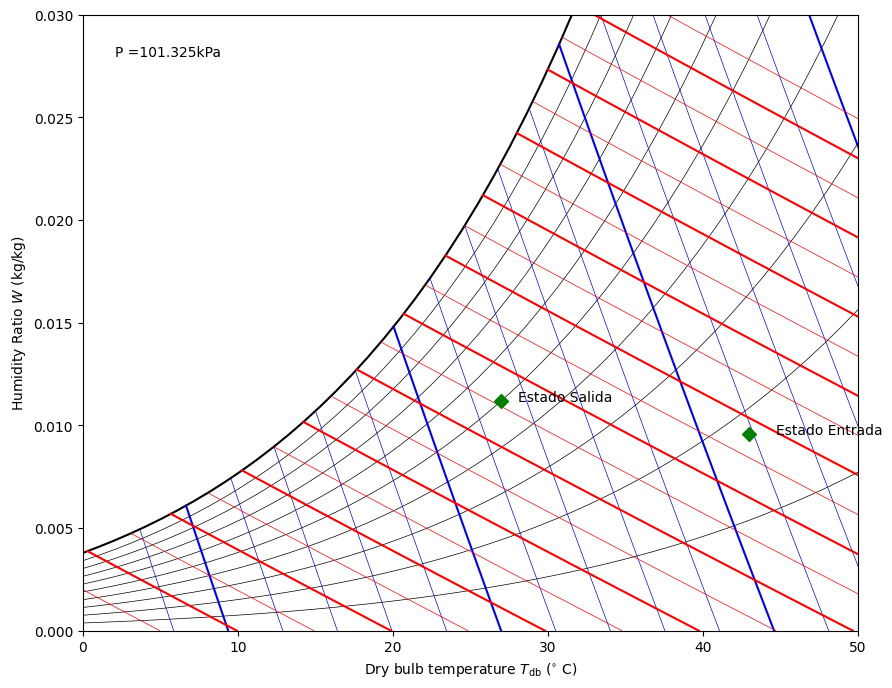

In [13]:
fig, ax = plt.subplots(1,1,figsize=(10, 8))
Tdbvec = np.linspace(0, 50)+273.15

# Lines of constant relative humidity
for RH in np.arange(0.1, 1, 0.1):
    W = cp.HAPropsSI("W","R",RH,"P",P.magnitude,"T",Tdbvec)
    plt.plot(Tdbvec-273.15, W, color='k', lw = 0.5)

# Saturation curve
W = cp.HAPropsSI("W","R",1,"P",P.magnitude,"T",Tdbvec)
plt.plot(Tdbvec-273.15, W, color='k', lw=1.5)

# Lines of constant Vda
for Vda in np.arange(0.79, 1.041, 0.01):
    R = np.linspace(0,1)
    W = cp.HAPropsSI("W","R",R,"P",P.magnitude,"Vda",Vda)
    Tdb = cp.HAPropsSI("Tdb","R",R,"P",P.magnitude,"Vda",Vda)
    plt.plot(Tdb-273.15, W, color='b', lw=1.5 if abs(Vda % 0.05) < 0.001 else 0.5)

# Lines of constant Enthalpy
for h in np.arange(0, 120, 5):
    R = np.linspace(0.0, 1)
    Tdb = cp.HAPropsSI("Tdb","R",R,"P",P.magnitude,"H",h*1000)
    W = cp.HAPropsSI("W","R",R,"P",P.magnitude,"Tdb",Tdb)
    plt.plot(Tdb-273.15, W, color='r', lw=1.5 if abs(h % 10) < 0.001 else 0.5)

ax.annotate('P =' + f'{P.magnitude/1000}' + 'kPa', xy=(2, 0.0275), xytext=(2.1,0.028))

# Puntos con los estado termodinámicos
e_h = 1.04 # Espaciamiento horizontal
# Estado Entrada
plt.scatter(T_in.magnitude, w_in, c='g',s=50,zorder=5,marker='D') 
plt.annotate('Estado Entrada', ((T_in.magnitude)*e_h, w_in))
# Estado Salida
plt.scatter(T_out.to(u.celsius).magnitude, w_out, c='g',s=50,zorder=5,marker='D') 
plt.annotate('Estado Salida', ((T_out.to(u.celsius).magnitude)*e_h, w_out))

plt.xlabel(r'Dry bulb temperature $T_{\rm db}$ ($^{\circ}$ C)')
plt.ylabel(r'Humidity Ratio $W$ (kg/kg)')
plt.ylim(0, 0.030)
plt.xlim(0, 50)
plt.show()

## Parte C

Basado en el desarrollo de la parte (A), se definen las siguientes funciones

In [14]:
def mass_air(T, HR, P, flow_rates):
    V = cp.HAPropsSI('V', 'T', T.magnitude, 'R', HR, 'P', P.magnitude)*u.m**3/u.kilogram
    m_a = flow_rates / V
    return m_a

def calculate_w_in(m_a, m_v, w_out):
    w_in = w_out - m_v/m_a
    return w_in

def calculate_h_in(m_a, q_in, h_out):
    h_in = h_out + q_in/m_a
    return h_in

def Temp_in(w, h, P):
    T_in = cp.HAPropsSI('T', 'W', w, 'H', h.magnitude, 'P', P.magnitude)*u.kelvin
    return T_in.to(u.celsius)

def R_in(w, h, P):
    R_in = cp.HAPropsSI('R', 'W', w, 'H', h.magnitude, 'P', P.magnitude)
    return R_in

Definiendo el rango de flujos de interés, se resuelve numéricamente los arreglos correspondientes y se grafican

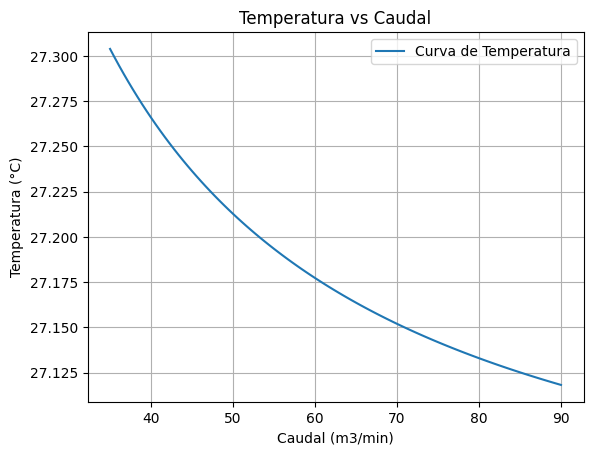

In [15]:
flow_rates = np.linspace(35,90,100)*u.m**3/u.s

m_a_range = mass_air(T_out, HR_out, P, flow_rates)
w_in_range = np.zeros(100)
h_in_range = np.zeros(100)*u.joule/u.kilogram
for i in range(100):
    w_in_range[i] = calculate_w_in(m_a_range[i], m_v, w_out)
    h_in_range[i] = calculate_h_in(m_a_range[i], q_in, h_out)

T_range = [Temp_in(w_in_range[i], h_in_range[i], P).magnitude for i in range(100)]

# plot curva de sistema
plt.plot(flow_rates.magnitude, T_range, label='Curva de Temperatura')

# aspectos visuales
plt.xlabel('Caudal (m3/min)')
plt.ylabel('Temperatura (°C)')
plt.title('Temperatura vs Caudal')
plt.legend()
plt.grid(True)
plt.show()

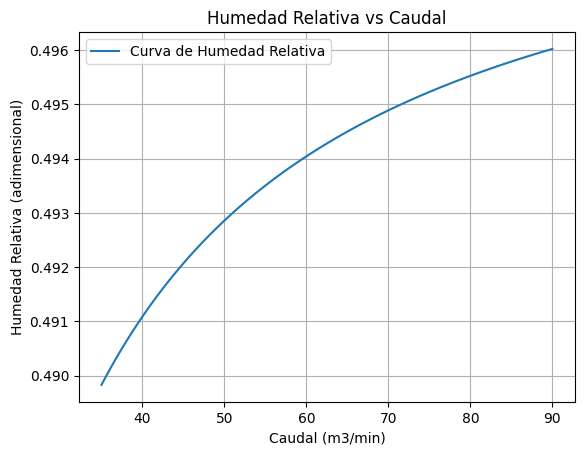

In [16]:
R_range = [cp.HAPropsSI('R', 'H', h_in_range[i].magnitude, 'W', w_in_range[i], 'P', P.magnitude) for i in range(100)]

# plot curva de sistema
plt.plot(flow_rates.magnitude, R_range, label='Curva de Humedad Relativa')

# aspectos visuales
plt.xlabel('Caudal (m3/min)')
plt.ylabel('Humedad Relativa (adimensional)')
plt.title('Humedad Relativa vs Caudal')
plt.legend()
plt.grid(True)
plt.show()

# Pregunta 3
Considere los datos de la instalación de APR en Hualañé, incluyendo la distribución de diámetros y
la bomba seleccionada en las entregas anteriores.

a) (3pts) Verique el pñunto de operación y si se cumple la jnormativa, en el escenario que 3 nuevas
vivuiendas sean construídas en el sector más alto de Hualañé.

b) (3pts) Sugiera una solución a la situación anteior, para asegurar el suministro bajo las normas de
servicios sanitarios.

### Existen muchas incongruencias de las entregas anteriores, por lo que se revisa el código completo.

In [309]:
T = (20*u.celsius).to(u.K) # Temperatura del suelo
P = (49*u.kPa).to(u.Pa) # Considerando la mínima presión requerida por norma

epsilon = (0.0015*u.mm).to(u.m) # Rugosidad del tubo [1]

rho = cp.PropsSI('D','T', T.magnitude, 'P', P.magnitude, 'water')*u.kg/u.m**3
mu = cp.PropsSI('V','T', T.magnitude, 'P', P.magnitude, 'water')*u.Pa*u.s

Se parte revisando el código de las entregas anteriores, a continuación, las distancias y alturas de las casas de izquierda a derecha.

In [310]:
lC1 = [3.67, 17.39, 27.31, 3.39, 28.34, 193.36]*u.m
lC2 = [3.67, 17.39, 27.31, 3.39, 14.53, 2.91, 88.35]*u.m
lC3 = [3.67, 17.39, 27.31, 3.39, 14.53, 5, 153.65]*u.m
lC4 = [3.67, 17.39, 27.31, 12.05]*u.m
lC5 = [3.67, 17.39, 4.61]*u.m
lC6 = [3.67, 27.36, 17.27, 1.96, 27.98, 23.00]*u.m
lC7 = [3.67, 27.36, 17.27, 1.96, 29.37]*u.m
lC8 = [3.67, 27.36, 17.27, 29.60, 110.27]*u.m
lC9 = [3.67, 27.36, 17.27, 29.60, 8.39, 14.08]*u.m
lC10 = [3.67, 27.36, 22.43, 41.89]*u.m
lC11 = [3.67, 27.36, 22.43, 68.08, 14.31]*u.m
lC12 = [3.67, 27.36, 22.43, 68.08, 3.17, 14.09, 4.98, 15.00]*u.m
lC13 = [3.67, 27.36, 22.43, 68.08, 3.17, 14.09, 7.00, 2.00]*u.m
lC14 = [3.67, 27.36, 22.43, 68.08, 3.17, 21.94, 5.85]*u.m
lC15 = [3.67, 27.36, 22.43, 68.08, 3.17, 21.94, 15.58, 5.89]*u.m
lC16 = [3.67, 27.36, 22.43, 68.08, 3.17, 21.94, 15.58, 22.89, 73.05]*u.m
lC17 = [3.67, 27.36, 22.43, 68.08, 3.17, 21.94, 15.58, 22.89, 14.28, 3.99, 3.05]*u.m
lC18 = [3.67, 27.36, 22.43, 68.08, 3.17, 21.94, 15.58, 22.89, 14.28, 2.04, 1.66]*u.m
lC19 = [3.67, 27.36, 22.43, 68.08, 3.17, 21.94, 15.58, 22.89, 14.28, 2.04, 2.04, 16.11]*u.m

In [311]:
hB = 113
hC1 = (107.3-hB)*u.m
hC2 = (110.7-hB)*u.m
hC3 = (112-hB)*u.m
hC4 = (111-hB)*u.m
hC5 = (112.2-hB)*u.m
hC6 = (113.3-hB)*u.m
hC7 = (114.5-hB)*u.m
hC8 = (116.1-hB)*u.m
hC9 = (116.7-hB)*u.m
hC10 = (115.7-hB)*u.m
hC11 = (119.6-hB)*u.m
hC12 = (119.5-hB)*u.m
hC13 = (120.1-hB)*u.m
hC14 = (121.0-hB)*u.m
hC15 = (121.6-hB)*u.m
hC16 = (123.6-hB)*u.m
hC17 = (122.7-hB)*u.m
hC18 = (123.0-hB)*u.m
hC19 = (123.7-hB)*u.m

Se optimiza el sistema de tuberías para tener pérdidas de presión similares

In [312]:
Q = 190
Qpi1, Qpi2, Qpi3 = 50, 40, 30
Qpd1, Qpd2, Qpd3, Qpd4, Qpd5, Qpd6, Qpd7 = 140, 100, 90, 80, 60, 50, 40
Qb1, Qb2, Qb2i, Qb2d, Qb3, Qb4, Qb4d = 20, 40, 20, 20, 20, 30, 20
Qc = 10


In [313]:
QC1 = [Q, Qpi1, Qpi2, Qpi3, Qc, Qc]*u.L/u.min
QC2 = [Q, Qpi1, Qpi2, Qpi3, Qb1, Qc, Qc]*u.L/u.min
QC3 = [Q, Qpi1, Qpi2, Qpi3, Qb1, Qc, Qc]*u.L/u.min
QC4 = [Q, Qpi1, Qpi2, Qc]*u.L/u.min
QC5 = [Q, Qpi1, Qc]*u.L/u.min
QC6 = [Q, Qpd1, Qb2, Qb2i, Qc, Qc]*u.L/u.min
QC7 = [Q, Qpd1, Qb2, Qb2i, Qc]*u.L/u.min
QC8 = [Q, Qpd1, Qb2, Qb2d, Qc]*u.L/u.min
QC9 = [Q, Qpd1, Qb2, Qb2d, Qc, Qc]*u.L/u.min
QC10 = [Q, Qpd1, Qpd2, Qc]*u.L/u.min
QC11 = [Q, Qpd1, Qpd2, Qpd3, Qc]*u.L/u.min
QC12 = [Q, Qpd1, Qpd2, Qpd3, Qpd4, Qb3, Qc, Qc]*u.L/u.min
QC13 = [Q, Qpd1, Qpd2, Qpd3, Qpd4, Qb3, Qc, Qc]*u.L/u.min
QC14 = [Q, Qpd1, Qpd2, Qpd3, Qpd4, Qpd5, Qc]*u.L/u.min
QC15 = [Q, Qpd1, Qpd2, Qpd3, Qpd4, Qpd5, Qpd6, Qc]*u.L/u.min
QC16 = [Q, Qpd1, Qpd2, Qpd3, Qpd4, Qpd5, Qpd6, Qpd7, Qc]*u.L/u.min
QC17 = [Q, Qpd1, Qpd2, Qpd3, Qpd4, Qpd5, Qpd6, Qpd7, Qb4, Qc, Qc]*u.L/u.min
QC18 = [Q, Qpd1, Qpd2, Qpd3, Qpd4, Qpd5, Qpd6, Qpd7, Qb4, Qb4d, Qc]*u.L/u.min
QC19 = [Q, Qpd1, Qpd2, Qpd3, Qpd4, Qpd5, Qpd6, Qpd7, Qb4, Qb4d, Qc, Qc]*u.L/u.min

In [314]:
Db = 2
Dpi, Dpd = 1, 2
Db1, Db2, Db3, Db4 = 1, 1, 2, 2

Dc1, Dc2, Dc3, Dc4, Dc5 = 0.75, 0.75, 1, 0.5, 0.5
Dc6, Dc7, Dc8, Dc9, Dc10, Dc11, Dc12, Dc13, Dc14, Dc15, Dc16, Dc17, Dc18, Dc19 = 0.75, 0.75, 1, 0.75, 0.75, 1.5, 1.5, 1.5, 1.5, 1.5, 2, 2, 2, 2

In [315]:
DC1 = [Db, Dpi, Dpi, Dpi, Dpi, Dc1]*u.inch
DC2 = [Db, Dpi, Dpi, Dpi, Db1, Db1, Dc2]*u.inch
DC3 = [Db, Dpi, Dpi, Dpi, Db1, Db1, Dc3]*u.inch
DC4 = [Db, Dpi, Dpi, Dc4]*u.inch
DC5 = [Db, Dpi, Dc5]*u.inch
DC6 = [Db, Dpd, Db2, Db2, Db2, Dc6]*u.inch
DC7 = [Db, Dpd, Db2, Db2, Dc7]*u.inch
DC8 = [Db, Dpd, Db2, Db2, Dc8]*u.inch
DC9 = [Db, Dpd, Db2, Db2, Db2, Dc9]*u.inch
DC10 = [Db, Dpd, Dpd, Dc10]*u.inch
DC11 = [Db, Dpd, Dpd, Dpd, Dc11]*u.inch
DC12 = [Db, Dpd, Dpd, Dpd, Dpd, Db3, Db3, Dc12]*u.inch
DC13 = [Db, Dpd, Dpd, Dpd, Dpd, Db3, Db3, Dc13]*u.inch
DC14 = [Db, Dpd, Dpd, Dpd, Dpd, Dpd, Dc14]*u.inch
DC15 = [Db, Dpd, Dpd, Dpd, Dpd, Dpd, Dpd, Dc15]*u.inch
DC16 = [Db, Dpd, Dpd, Dpd, Dpd, Dpd, Dpd, Dpd, Dc16]*u.inch
DC17 = [Db, Dpd, Dpd, Dpd, Dpd, Dpd, Dpd, Dpd, Db4, Db4, Dc17]*u.inch
DC18 = [Db, Dpd, Dpd, Dpd, Dpd, Dpd, Dpd, Dpd, Db4, Db4, Dc18]*u.inch
DC19 = [Db, Dpd, Dpd, Dpd, Dpd, Dpd, Dpd, Dpd, Db4, Db4, Db4, Dc19]*u.inch

Se calcula la pérdida de presión para cada casa

In [316]:
fun_Re = lambda D,Q: fld.Reynolds(D=D, rho=rho, mu=mu, V=Q/(np.pi*D**2/4)).to(u.dimensionless)
fun_f = lambda D,Q: fld.friction_factor(Re=fun_Re(D,Q), eD=epsilon/D).to(u.dimensionless)
fun_DP = lambda D,L,Q: rho* fun_f(D, Q) * L/D * (Q/(np.pi*(D/2)**2))**2

def total_DP(L, D, z, Q):
    Q = Q.to(u.m**3/u.s)
    D = D.to(u.m)
    DP = 0
    for i in range(len(L)):
        DPi = fun_DP(D[i], L[i], Q[i]).to(u.Pa)
        DP += DPi
    DP += rho*g*z
    return (DP.to(u.kPa)).magnitude

In [322]:
DP_max = 0
DP_min = 100
DP_T = 0
for i in range(19):
    L_C = locals()[f"lC{i+1}"]
    D_C = locals()[f"DC{i+1}"]
    Q_C = locals()[f"QC{i+1}"]
    z_C = locals()[f"hC{i+1}"]
    total_DP_C = total_DP(L_C, D_C, z_C, Q_C)
    if total_DP_C > DP_max:
        DP_max = total_DP_C
    if total_DP_C < DP_min:
        DP_min = total_DP_C
    print(f"La pérdida de carga total para la casa {i+1} es {total_DP_C} kPa")
print()
print(f"La mayor diferencia de presiones entre dos casas es {DP_max - DP_min} kPa\n")
print(f"La mayor pérdida de carga en el sistema es {DP_max} kPa")
Hp = (DP_max*u.kPa/rho/g).to(u.m)
print(f"En base a esto, el head pump requerido es de {Hp.magnitude} m")

La pérdida de carga total para la casa 1 es 142.68883982708388 kPa
La pérdida de carga total para la casa 2 es 122.40908318611561 kPa
La pérdida de carga total para la casa 3 es 108.90557607556192 kPa
La pérdida de carga total para la casa 4 es 112.0478335449067 kPa
La pérdida de carga total para la casa 5 es 53.251383382624105 kPa
La pérdida de carga total para la casa 6 es 65.09047811220265 kPa
La pérdida de carga total para la casa 7 es 76.41217467778458 kPa
La pérdida de carga total para la casa 8 es 104.22965647451637 kPa
La pérdida de carga total para la casa 9 es 103.62869822507099 kPa
La pérdida de carga total para la casa 10 es 73.41494535369237 kPa
La pérdida de carga total para la casa 11 es 105.64337141387674 kPa
La pérdida de carga total para la casa 12 es 105.56786199204939 kPa
La pérdida de carga total para la casa 13 es 111.18725936795117 kPa
La pérdida de carga total para la casa 14 es 122.37707377104509 kPa
La pérdida de carga total para la casa 15 es 129.581054330211

Dada la diferencia de altura, los largos de cada tubería, y la oferta limitada de diámteros de tubería, no es posible dar menor diferencia a las presiones para cada casa.

Para estar de acuerdo a la norma, se requiere por lo menos $5mca$ cuando la llave está abierta, por lo tanto, se le debe sumar esos $5m$ al head pump obtenido.

Con los 20.5m de altura de presión y 190L/min de caudal, se seleccion la bomba bomba B1-1/2T_L del catálogo Berkeley.

In [324]:
Qt = (190*u.L/u.min).to(u.gal/u.min)
print(f"Q = {Q}")
Hpt = (Hp+5*u.m).to(u.ft)
print(f"Hp = {Hpt}")

Q = 190
Hp = 67.33782286414993 foot


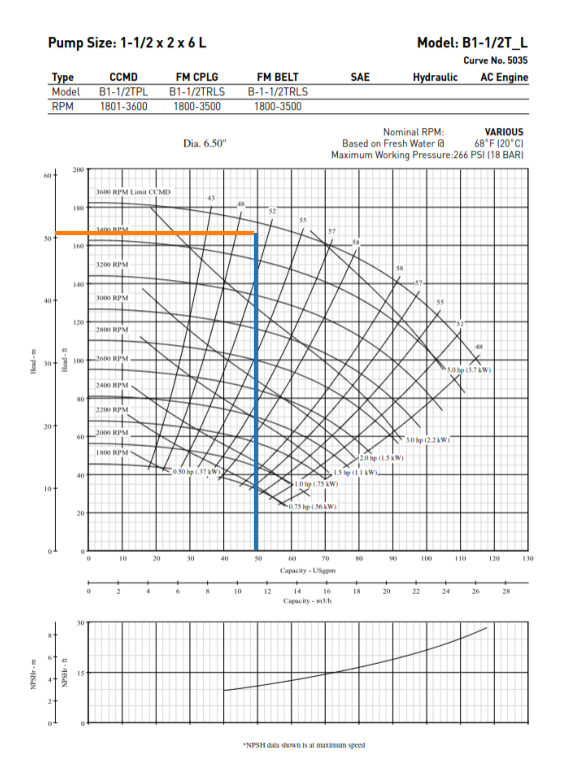

In [319]:
plt.figure(dpi=200)
plt.imshow(plt.imread("Bomba_t3_3.png"))
plt.axis('off')

plt.plot(50*np.ones(100) + 240, 100*np.linspace(0,1,100)*3.85 + 265)
plt.plot(50*np.linspace(0,1,100)*4.8 + 45, 100*np.ones(100) + 162)

plt.show()

Por lo tanto, se puede hacer funcionar el modelo a $\omega=3600RPM$, obteniendo así una eficiencia de $\mu=50\%$ y al rededor de $4.0hp$ de potencia.

### Ahora si, al encargo de esta tarea
Lo primero que se debe considerar es el caudal al que se somete la bomba, para las tareas anteriores, se consideró un caudal de $10\frac{L}{min}$ por casa, el cual se vería disminuido a $8.64\frac{L}{min}$. Si bien el caudal no está normado, se utilizó el margen inferior de lo recomendado [3]. Para que el sistema tenga un buen funcionamiento, se aumenta el caudal en $30\frac{L}{min}$. Tomando la casa con más pérdida de carga, la cual se ubica arbitariamente a $74m$ del final de la tubería principal, se recalcula la pérdida de carga esperada.

In [305]:
Dce = 2
lCe = [3.67, 27.36, 22.43, 68.08, 3.17, 21.94, 15.58, 22.89, 74]*u.m
QCe = [Q+30, Qpd1+30, Qpd2+30, Qpd3+30, Qpd4+30, Qpd5+30, Qpd6+30, Qpd7+30, Qc]*u.L/u.min
DCe = [Db, Dpd, Dpd, Dpd, Dpd, Dpd, Dpd, Dpd, Db4, Db4, Db4, Dce]*u.inch
hCe = (124.05-hB)*u.m
DP_new = total_DP(lCe, DCe, hCe, QCe)
print(f"La pérdida de carga total para la casa extra es {total_DP_C} kPa")
print(f"La mayor pérdida de carga en el sistema es {total_DP_C} kPa")
Hp = (DP_new*u.kPa/rho/g).to(u.ft)
print(f"En base a esto, el head pump requerido es de {Hp.magnitude} m")

La pérdida de carga total para la casa extra es 184.20490210205324 kPa
La mayor pérdida de carga en el sistema es 184.20490210205324 kPa
En base a esto, el head pump requerido es de 61.69708198971565 m


El head pump obtenido no es realizable por la bomba seleccionada anteriormente.

# Bibliografía

[1] https://www.stainless-structurals.com/blog/comparing-the-thermal-conductivity-of-stainless-steel-to-other-metals/

[2] http://catarina.udlap.mx/u_dl_a/tales/documentos/mgc/osorio_e_fj/capitulo3.pdf\

[3] https://www.junkers-bosch.es/conocimiento/agua-caliente/caudal-minimo/
